# 비상장 중소기업의 상장 후 주가 예측 프로젝트

이 프로젝트는 비상장 중소기업의 상장 후 주가 예측 프로젝트이다. 과거 중소기업의 데이터와 상장 후 주가의 산술평균 데이터를 이용할 것이다. 중소기업의 데이터는 기업 내 재무재표와 거시정보를 이용한다.

기본설정

In [9]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

In [17]:
data = pd.read_csv('datasets//DB//DB_data.csv', engine='python')

# 기업규모명

우리가 예측하고 싶은 대상은 중소기업이므로 중소기업만 관찰한다.

In [18]:
data = data[data["기업규모명"] == '중소기업']
data["산술평균"].describe()

count     19416.000000
mean       8766.464462
std       20051.864527
min          94.000000
25%        2300.000000
50%        4358.500000
75%        8742.000000
max      604000.000000
Name: 산술평균, dtype: float64

우리의 타겟값인 산술평균의 경우 평균은 8000이지만 최댓값은 604000이다. 주어진 데이터에 이상치가 많다고 판단되어 산술평균이 15000 이내의 데이터만 사용하도록 한다.

In [20]:
data = data[data["산술평균"] < 150000]
data["산술평균"].describe()

count     19384.000000
mean       8169.842396
std       12313.519334
min          94.000000
25%        2297.000000
50%        4351.500000
75%        8710.250000
max      149179.000000
Name: 산술평균, dtype: float64

평균은 8766에서 8169로 줄어들었지만, 최댓값은 149179다.

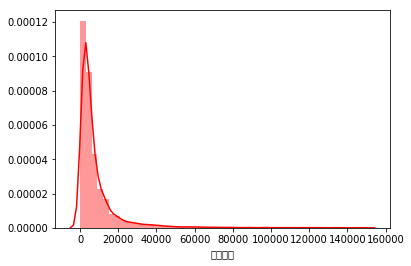

In [21]:
import seaborn as sns

sns.distplot(data["산술평균"], color='red')
plt.show()

주어진 데이터의 오른쪽 꼬리가 길게 뻗어있다.

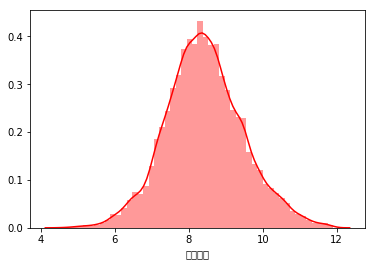

In [22]:
sns.distplot(np.log(data["산술평균"]+ 1), color='red')
plt.show()

주어진 타겟값을 log화하니, 정규분포의 모습과 상당히 비슷해졌다. 나중에 타겟값을 나중에 log화 해야한다.

# 데이터 구조 훑어보기

우리의 데이터를 간략하게 살펴보자.

In [23]:
data.head()

,회사명,회계년도,산업명,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),...,현금의 증가(감소)(*),기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,9917659.0,3104211.0,15477735.0,4969819.0,...,-265171.0,중소기업,873.0,1.0,34.1,81.3,4.2,1939.30,-4253.0,108887244.0
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11341653.0,3071427.0,14731279.0,5976935.0,...,-1160724.0,중소기업,577.0,0.6,34.1,80.6,3.4,2142.47,-2470.6,108887244.0
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11407699.0,3352328.0,14717723.0,6389723.0,...,-1961689.0,중소기업,993.0,0.7,34.8,80.9,3.1,1880.11,11405.6,108887244.0
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,12521782.0,2743103.0,12283654.0,7620349.0,...,-1294857.0,중소기업,775.0,0.6,35.2,79.3,2.9,1847.51,11956.2,108887244.0
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,13370740.0,3654331.0,12100895.0,8146944.0,...,435947.0,중소기업,892.0,0.5,34.3,79.7,3.8,2045.08,-1292.0,108887244.0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19384 entries, 0 to 47807
Data columns (total 41 columns):
회사명                  19384 non-null object
회계년도                 19384 non-null object
산업명                  19384 non-null object
소속코드                 19384 non-null float64
설립일                  19384 non-null object
종업원                  19384 non-null float64
당좌자산(*)              19113 non-null float64
재고자산(*)              19113 non-null float64
비유동자산(*)             19113 non-null float64
유동부채(*)              19113 non-null float64
비유동부채(*)             19113 non-null float64
자본금(*)               19113 non-null float64
자본잉여금(*)             19113 non-null float64
자본조정(*)              19113 non-null float64
기타포괄손익누계액(*)         19113 non-null float64
이익잉여금(*)             19113 non-null float64
매출액(영업수익)(*)         19113 non-null float64
매출원가(*)              19113 non-null float64
매출총이익(손실)            19113 non-null float64
판매비와관리비(영업비용)(*)     19113 non-null float64
영업이익(손실)       

1. 데이터에는 결측치가 몇 개 보인다.
2. 데이터 타입이 object인 데이터는, 회사명, 회계년도, 산업명, 설립일이 있다.
    - 회사명의 경우 각 데이터의 identity column이므로 나중에 삭제한다.
    - 회계년도의 경우 나중에 분기(03, 06, 09, 12)만 얻어서 명목형 변수로 변환한다.
    - 설립일의 경우년도만 얻어서 수치형 자료로 사용하겠다.
3. 소속코드의 경우 산술 평균과 연관있는 데이터이므로 나중에 삭제해야한다.

# 파일 정제

결측치가 몇 개 보인다. 산술평균의 경우 우리의 타겟값이므로 산술평균에 결측치가 있는 경우 객체를 버린다.

In [25]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19384 entries, 0 to 47807
Data columns (total 41 columns):
회사명                  19384 non-null object
회계년도                 19384 non-null object
산업명                  19384 non-null object
소속코드                 19384 non-null float64
설립일                  19384 non-null object
종업원                  19384 non-null float64
당좌자산(*)              19113 non-null float64
재고자산(*)              19113 non-null float64
비유동자산(*)             19113 non-null float64
유동부채(*)              19113 non-null float64
비유동부채(*)             19113 non-null float64
자본금(*)               19113 non-null float64
자본잉여금(*)             19113 non-null float64
자본조정(*)              19113 non-null float64
기타포괄손익누계액(*)         19113 non-null float64
이익잉여금(*)             19113 non-null float64
매출액(영업수익)(*)         19113 non-null float64
매출원가(*)              19113 non-null float64
매출총이익(손실)            19113 non-null float64
판매비와관리비(영업비용)(*)     19113 non-null float64
영업이익(손실)       

데이터의 특성중 당좌좌산(\*)부터 현금의 증가(감소)(\*)의 경우 결측치의 개수가 일정한 것으로보아, 이 중 한 특성에서 결측치가 발생한 경우, 다른 특성에도 결측치가 발생한 것으로 추론할 수 있다.

In [26]:
data = data[-data["당좌자산(*)"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19113 entries, 0 to 47807
Data columns (total 41 columns):
회사명                  19113 non-null object
회계년도                 19113 non-null object
산업명                  19113 non-null object
소속코드                 19113 non-null float64
설립일                  19113 non-null object
종업원                  19113 non-null float64
당좌자산(*)              19113 non-null float64
재고자산(*)              19113 non-null float64
비유동자산(*)             19113 non-null float64
유동부채(*)              19113 non-null float64
비유동부채(*)             19113 non-null float64
자본금(*)               19113 non-null float64
자본잉여금(*)             19113 non-null float64
자본조정(*)              19113 non-null float64
기타포괄손익누계액(*)         19113 non-null float64
이익잉여금(*)             19113 non-null float64
매출액(영업수익)(*)         19113 non-null float64
매출원가(*)              19113 non-null float64
매출총이익(손실)            19113 non-null float64
판매비와관리비(영업비용)(*)     19113 non-null float64
영업이익(손실)       

이 중 발행주식수에 결측치가 있는 샘플이 있는데 샘플의 개수가 적어서 객체를 버리는 것이 좋을 것 같다.

In [27]:
data = data[-data["발행주식수"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19086 entries, 0 to 47807
Data columns (total 41 columns):
회사명                  19086 non-null object
회계년도                 19086 non-null object
산업명                  19086 non-null object
소속코드                 19086 non-null float64
설립일                  19086 non-null object
종업원                  19086 non-null float64
당좌자산(*)              19086 non-null float64
재고자산(*)              19086 non-null float64
비유동자산(*)             19086 non-null float64
유동부채(*)              19086 non-null float64
비유동부채(*)             19086 non-null float64
자본금(*)               19086 non-null float64
자본잉여금(*)             19086 non-null float64
자본조정(*)              19086 non-null float64
기타포괄손익누계액(*)         19086 non-null float64
이익잉여금(*)             19086 non-null float64
매출액(영업수익)(*)         19086 non-null float64
매출원가(*)              19086 non-null float64
매출총이익(손실)            19086 non-null float64
판매비와관리비(영업비용)(*)     19086 non-null float64
영업이익(손실)       

이제 우리의 데이터에 결측치가 있는 샘플이 없어졌다.

# 데이터 구조

## 명목형 변수

### 산업명

각 산업명의 경우에 얼마나 샘플이 속해있는지 살펴보자.

In [28]:
data["산업명"].value_counts()

  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업    3949
  기타 기계 및 장비 제조업                  2088
  출판업                             1447
  의료용 물질 및 의약품 제조업                1309
  도매 및 상품 중개업                     1207
  화학물질 및 화학제품 제조업; 의약품 제외          984
  의료, 정밀, 광학기기 및 시계 제조업            838
  자동차 및 트레일러 제조업                   709
  전기장비 제조업                         665
  금속가공제품 제조업; 기계 및 가구 제외           589
  고무 및 플라스틱제품 제조업                  521
  컴퓨터 프로그래밍, 시스템 통합 및 관리업          419
  1차 금속 제조업                        370
  영상ㆍ오디오 기록물 제작 및 배급업              288
  연구개발업                            268
  정보서비스업                           260
  식료품 제조업                          259
  기타 운송장비 제조업                      238
  비금속 광물제품 제조업                     210
  의복, 의복 액세서리 및 모피제품 제조업           198
  종합 건설업                           198
  펄프, 종이 및 종이제품 제조업                196
  섬유제품 제조업; 의복제외                   175
  기타 전문, 과학 및 기술 서비스업              144
  소매업; 자동차 제외                      143
  전문 서비스업                

이 데이터를 시각화 해보자.

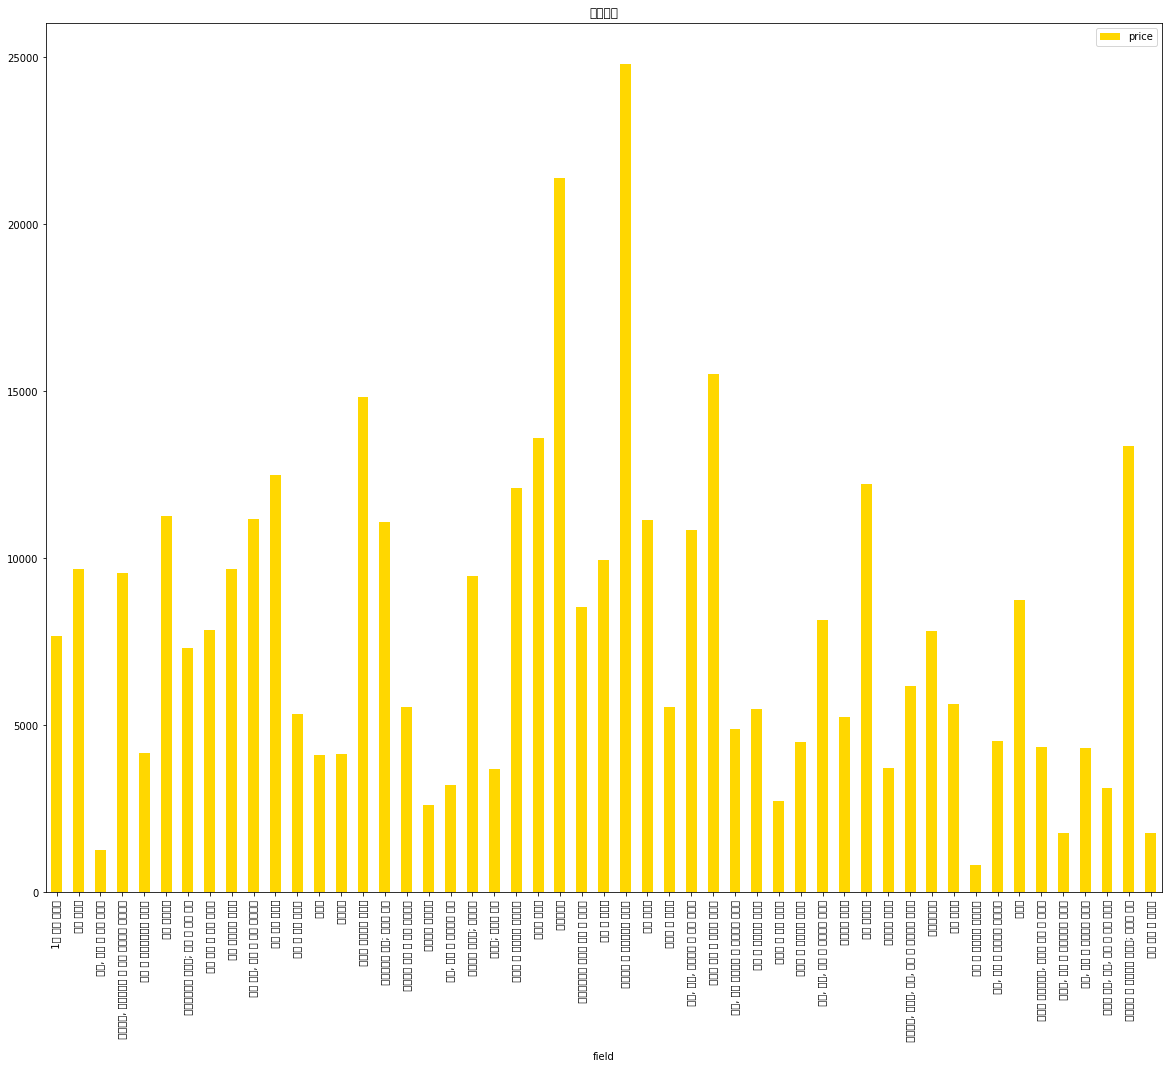

In [30]:
tmp = data[["산업명","산술평균"]].copy()
tmp.columns = ["field", "price"]

tmp.groupby(['field']).mean().plot.bar(figsize=(20,16), color='gold')
plt.title('몰로하징')
plt.show()

### 특징 설명하기

## 수치형 데이터

### 설립일

설립일에 따른 산술 평균

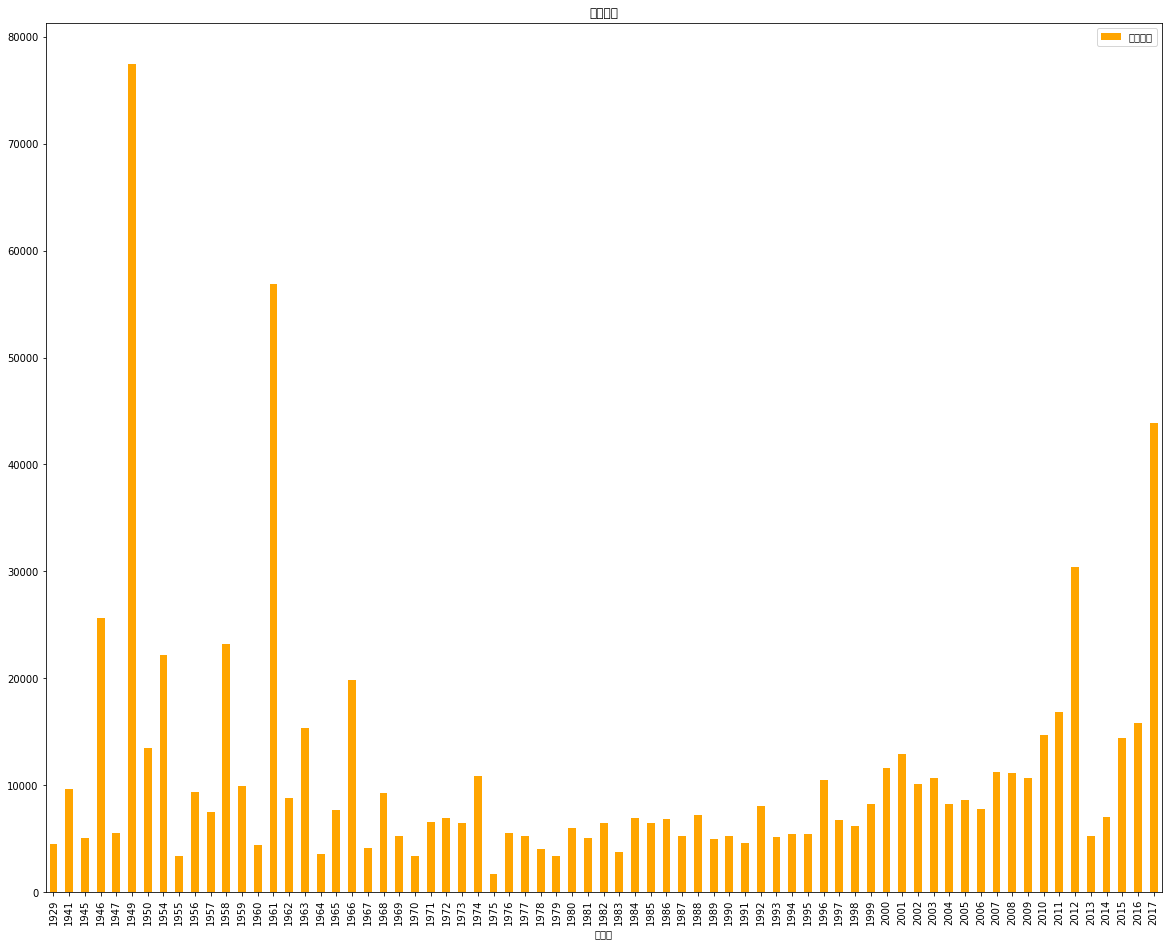

In [31]:
data_est_stock = data[["설립일", '산술평균']].copy()
data_est_stock["설립일"] = data_est_stock["설립일"].str.split('-', n=2, expand=True)[0]

data_est_stock.groupby("설립일").mean().plot.bar(figsize=(20,16), color='orange')
plt.title('몰로하징')
plt.show()

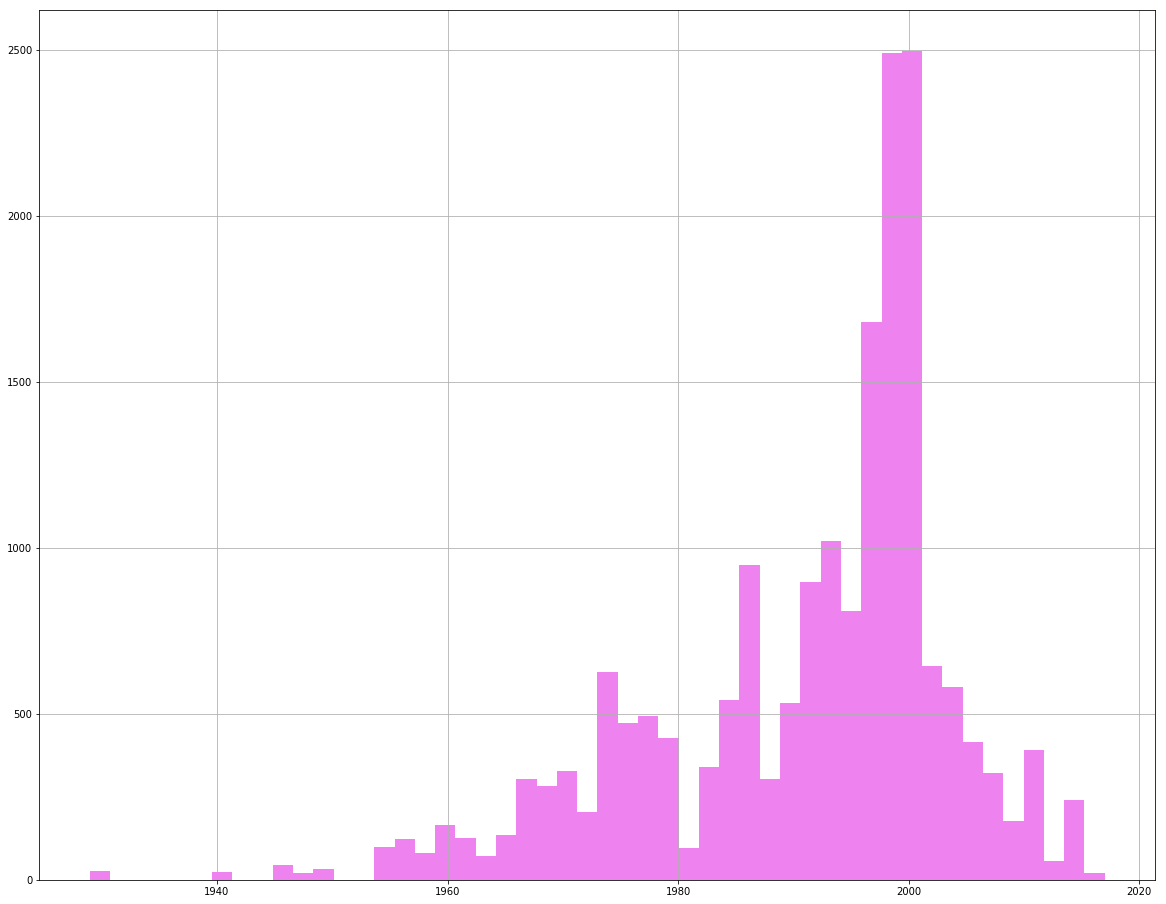

In [55]:
data_est_stock["설립일"].astype('float').hist(bins=50, figsize=(20,16), color='violet')
plt.show()

왼쪽 꼬리에 있는 데이터의 산술평균의 값이 크다.

### 다른 수치형 데이터

In [32]:
data.iloc[:, :20].describe()

,소속코드,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),비유동부채(*),자본금(*),자본잉여금(*),자본조정(*),기타포괄손익누계액(*),이익잉여금(*),매출액(영업수익)(*),매출원가(*),매출총이익(손실),판매비와관리비(영업비용)(*)
count,19086.000000,19086.000000,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04
mean,4.519019,162.263544,3.040389e+07,7.871100e+06,3.990800e+07,2.190980e+07,7.252459e+06,9.194190e+06,2.337282e+07,-2.073750e+06,8.672901e+05,1.766120e+07,3.457476e+07,2.654156e+07,8.033203e+06,6.345833e+06
std,1.374505,151.949052,2.620828e+07,1.013689e+07,3.284685e+07,2.390732e+07,1.183046e+07,9.319149e+06,2.841415e+07,7.067283e+06,3.614713e+06,3.726912e+07,4.088414e+07,3.477984e+07,1.124125e+07,8.248054e+06
min,1.000000,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.267000e+03,0.000000e+00,-1.596257e+07,-2.760965e+08,-2.112511e+07,-9.113449e+08,0.000000e+00,0.000000e+00,-5.694467e+07,-1.589801e+06
25%,5.000000,70.000000,1.430046e+07,1.345098e+06,1.819486e+07,6.824105e+06,1.096587e+06,4.100000e+06,7.811688e+06,-2.190785e+06,0.000000e+00,-2.774348e+05,1.104175e+07,7.246579e+06,1.956008e+06,2.051512e+06
50%,5.000000,122.000000,2.362748e+07,4.985892e+06,3.244755e+07,1.428202e+07,3.601144e+06,6.061316e+06,1.603420e+07,-5.173370e+05,0.000000e+00,1.619626e+07,2.303814e+07,1.677423e+07,4.781530e+06,4.001712e+06
75%,5.000000,208.000000,3.883280e+07,1.082022e+07,5.266963e+07,2.945004e+07,9.218471e+06,1.043666e+07,2.928513e+07,0.000000e+00,3.613725e+04,3.438909e+07,4.447928e+07,3.410711e+07,1.019723e+07,7.599558e+06
max,6.000000,2044.000000,3.729392e+08,2.200540e+08,3.981119e+08,3.818411e+08,2.075276e+08,1.021334e+08,9.624228e+08,8.052018e+07,1.205210e+08,4.512118e+08,9.696468e+08,9.275899e+08,2.993679e+08,2.588650e+08


In [33]:
data.iloc[:, 20:].describe()

,영업이익(손실),영업외수익(*),영업외비용(*),법인세비용차감전(계속사업)손익,(계속사업손익)법인세비용,계속사업이익(손실),당기순이익(순손실),영업활동으로 인한 현금흐름(*),투자활동으로 인한 현금흐름(*),재무활동으로 인한 현금흐름(*),환율변동으로 인한 차이조정,현금의 증가(감소)(*),산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
count,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,1.908600e+04,19086.000000,19086.000000,19086.000000,19086.000000,19086.000000,19086.000000,19086.000000,1.908600e+04
mean,1.687370e+06,1.527531e+06,1.908881e+06,1.306020e+06,3.859500e+05,9.198390e+05,9.018003e+05,1.481996e+06,-3.628380e+06,2.376696e+06,-6.662486e+03,2.194346e+05,8244.431678,0.701284,35.163382,75.736970,3.461998,2038.069406,18225.985487,3.018821e+07
std,5.469268e+06,3.738963e+06,3.586448e+06,6.984352e+06,1.299519e+06,6.277756e+06,6.450787e+06,7.075306e+06,1.016893e+07,1.053863e+07,4.790576e+05,6.599327e+06,12382.840574,0.317053,0.948418,2.850417,0.440159,156.448971,8796.829766,4.674815e+07
min,-6.889257e+07,-1.279960e+05,-5.367481e+06,-8.926241e+07,-3.001637e+07,-8.926241e+07,-9.014527e+07,-2.058578e+08,-2.676693e+08,-8.060879e+07,-7.388740e+06,-1.147393e+08,94.000000,-0.200000,33.700000,71.800000,2.800000,1843.470000,-4253.000000,4.075920e+05
25%,-5.261525e+05,3.059712e+05,3.027115e+05,-8.811020e+05,0.000000e+00,-8.363862e+05,-8.565345e+05,-1.314728e+06,-5.224926e+06,-1.046195e+06,-2.669000e+03,-1.671663e+06,2320.000000,0.600000,34.300000,73.400000,3.100000,1939.300000,12833.000000,1.049045e+07
50%,7.875975e+05,7.150850e+05,8.551030e+05,7.422170e+05,5.380800e+04,6.696580e+05,6.662895e+05,7.783145e+05,-1.531937e+06,0.000000e+00,0.000000e+00,-3.587650e+04,4412.000000,0.700000,35.000000,75.400000,3.400000,1991.970000,21472.900000,1.709455e+07
75%,2.992639e+06,1.622577e+06,2.120462e+06,3.133531e+06,5.245208e+05,2.698404e+06,2.696855e+06,3.622304e+06,0.000000e+00,3.343857e+06,8.100000e+01,1.733536e+06,8813.750000,0.900000,36.000000,77.300000,3.800000,2068.540000,25944.500000,3.383292e+07
max,1.221906e+08,2.216431e+08,1.135795e+08,1.310193e+08,3.216537e+07,1.025524e+08,1.025524e+08,1.379502e+08,1.020507e+08,2.788928e+08,3.979105e+07,1.910787e+08,149179.000000,1.400000,37.000000,81.300000,4.300000,2476.370000,28086.900000,6.348184e+08


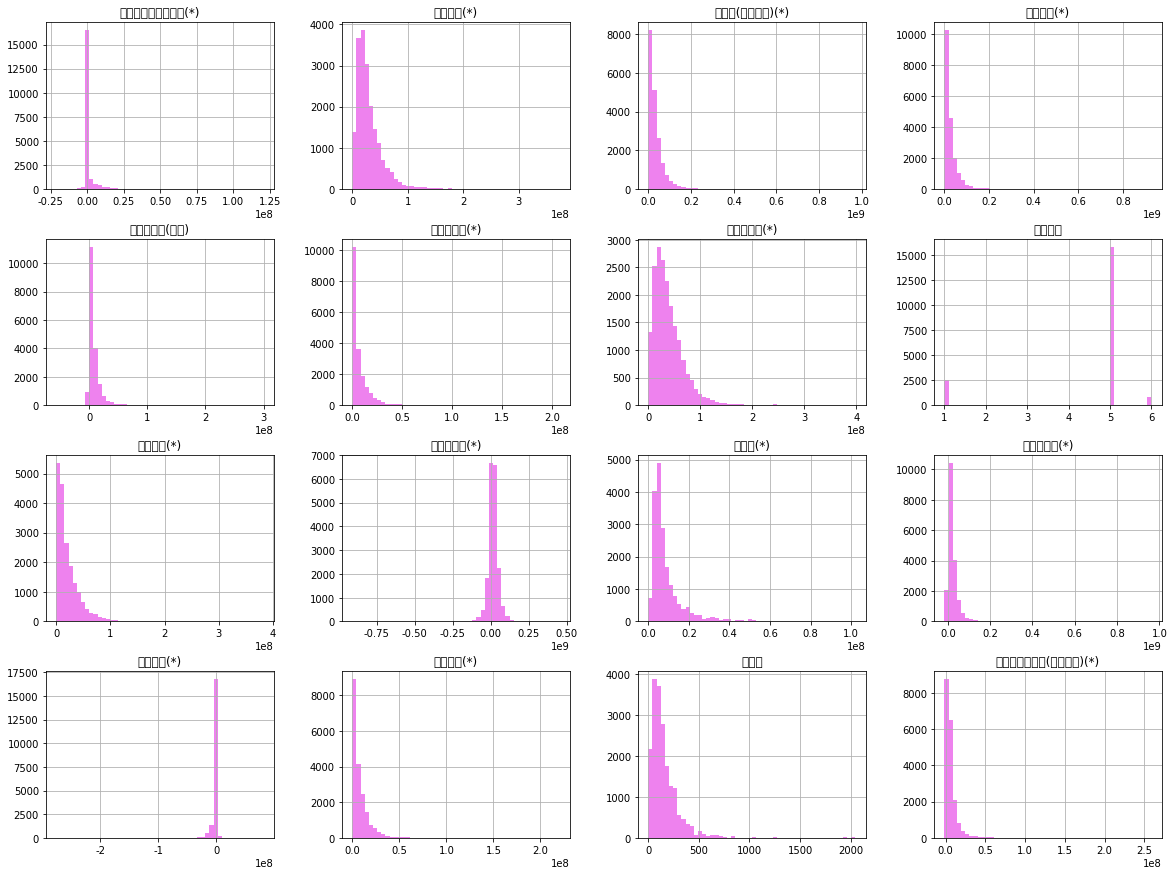

In [56]:
data.iloc[:,:20].hist(bins=50, figsize=(20,15), color='violet')
plt.show()

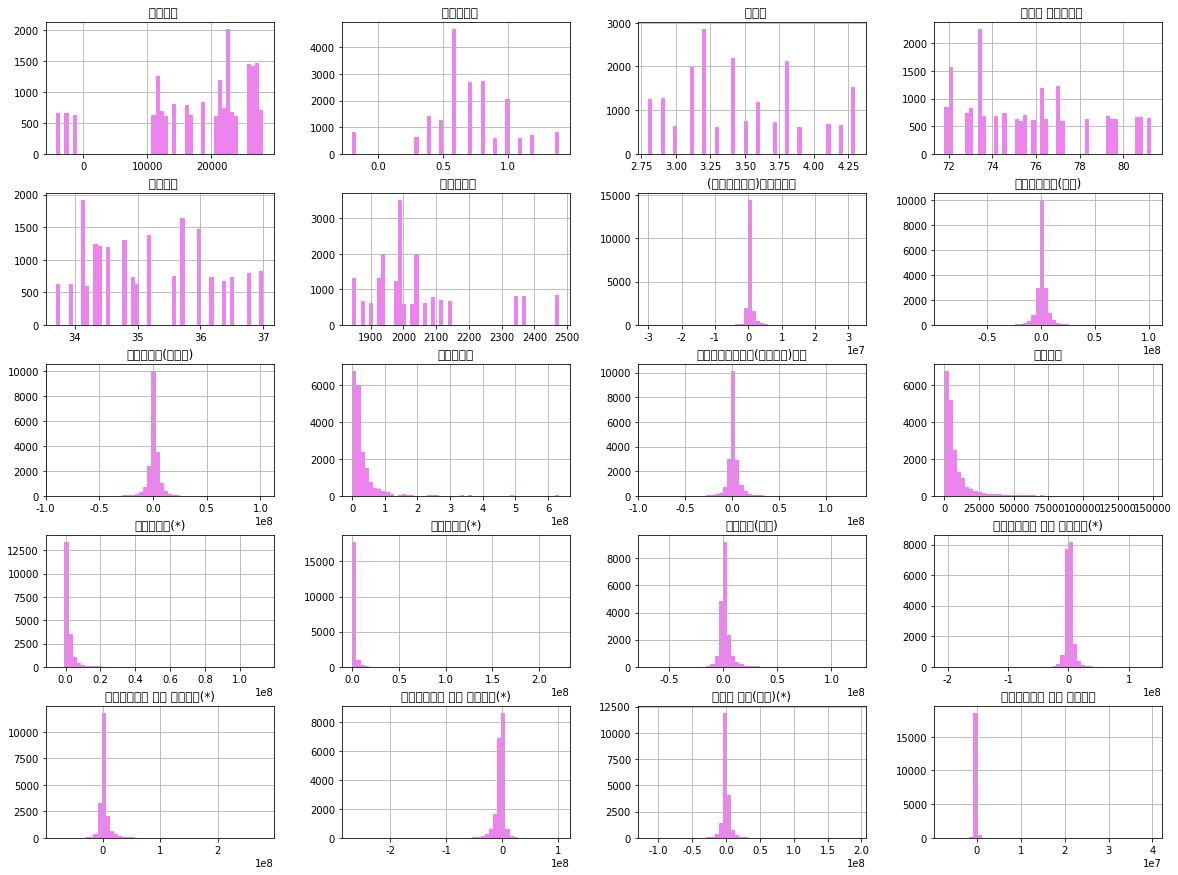

In [57]:
data.iloc[:,20:].hist(bins=50, figsize=(20,15),color='violet')
plt.show()

왼쪽에 데이터가 몰려있는 경우가 많으닌 몇 특성들을 골라서 log변환을 해야한다.

# 상관관계 조사

In [58]:
corr_matrix = data.corr()
corr_matrix["산술평균"].sort_values(ascending=False)

산술평균                 1.000000
당좌자산(*)              0.314169
영업이익(손실)             0.285946
이익잉여금(*)             0.269892
법인세비용차감전(계속사업)손익     0.267515
당기순이익(순손실)           0.255206
계속사업이익(손실)           0.254405
매출총이익(손실)            0.237877
(계속사업손익)법인세비용        0.208887
자본잉여금(*)             0.182660
영업활동으로 인한 현금흐름(*)    0.177060
비유동자산(*)             0.154320
종업원                  0.153367
판매비와관리비(영업비용)(*)     0.134591
  총저축률               0.112129
매출액(영업수익)(*)         0.103071
  경상수지               0.079065
현금의 증가(감소)(*)        0.078658
재무활동으로 인한 현금흐름(*)    0.072277
 코스피지수               0.061011
영업외수익(*)             0.060159
비유동부채(*)             0.056287
기타포괄손익누계액(*)         0.053458
  실업률                0.053131
매출원가(*)              0.044277
재고자산(*)              0.038259
유동부채(*)              0.006757
환율변동으로 인한 차이조정      -0.010338
  경제성장률             -0.012630
영업외비용(*)            -0.022188
소속코드                -0.036938
자본조정(*)             -0.104070
  제조업 평균가동률         -0.118707
투자활동으로 인한 

상관 관계가 높은 특성들은 "산술평균","영업이익(손실)", "당좌자산(\*)", "법인세비용차감전(계속사업)손익", "자본금(\*)","산술평균","당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"이다.

이를 산점도로 그려보자

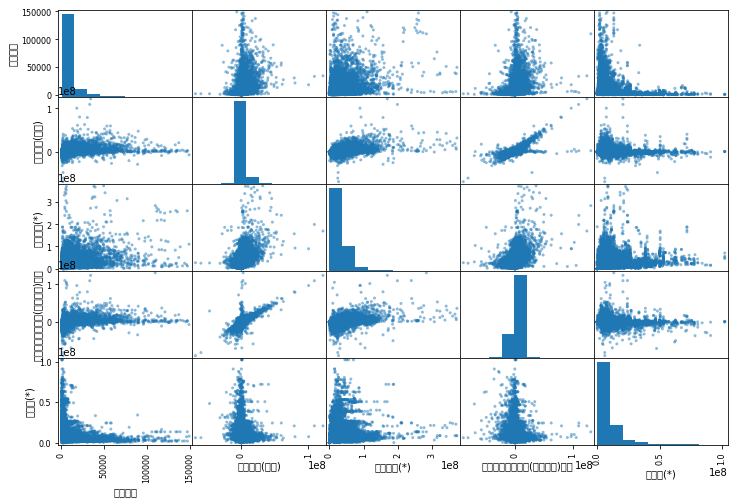

In [59]:
from pandas.plotting import scatter_matrix

attributes1 = ["산술평균","영업이익(손실)", "당좌자산(*)", "법인세비용차감전(계속사업)손익", "자본금(*)"]
scatter_matrix(data[attributes1], figsize=(12, 8))
plt.show()

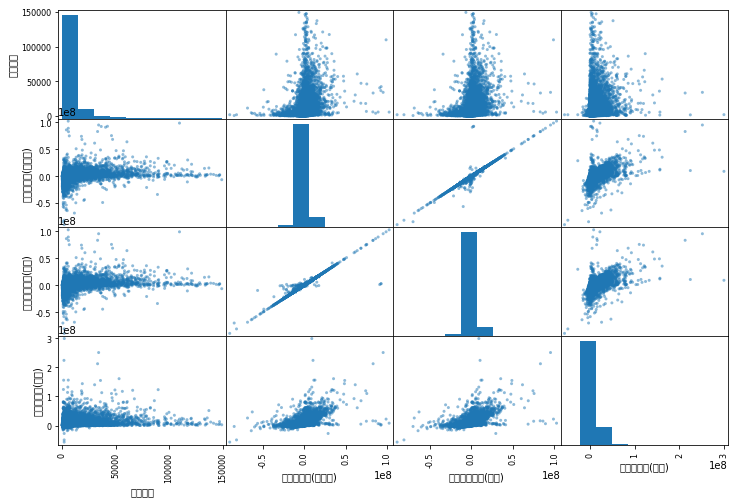

In [60]:
attributes2 = ["산술평균","당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"]
scatter_matrix(data[attributes2], figsize=(12, 8))
plt.show()

상관 관계를 조사해본 결과, 각 특성들끼리 상관도가 굉장히 높다. 이런 경우를 해결하기 위해 PCA 전처리를 추가해야한다.

#### 수치형 데이터 log화와 PCA

log화가 필요한 데이터들
1. 
2. 
3. 
4. 
5. 
6. 


# 머신러닝 알고리즘에 학습시키기 위해 데이터를 전처리하자.

1. train set, test set 나누기
2. 특성값, 타겟값 log화
3. 설립일에서 연도만 추출하기
4. 회계년도에서 분기 추출하기(명목화)